<img src="https://s3-sa-east-1.amazonaws.com/preditiva.ai/diversos/preditiva_assinatura.jpg">

# Redução de Dimensionalidade: AutoEncoder e t-SNE

## Hands On: Base de Vinhos

### Importação das bibliotecas

In [1]:
# Módulos de manipulação de dados
import numpy as np
import pandas as pd

# Módulos gráficos
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

# Módulos de modelagem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Métricas de Desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp

In [2]:
# Função para cálculo do KS
def ks_stat(y, y_pred):
    return ks_2samp(y_pred[y==1], y_pred[y!=1]).statistic

# Função para cálculo do desempenho de modelos
def calcula_desempenho(modelo, x_train, y_train, x_test, y_test):
    
    # Cálculo dos valores preditos
    ypred_train = modelo.predict(x_train)
    ypred_proba_train = modelo.predict_proba(x_train)[:,1]

    ypred_test = modelo.predict(x_test)
    ypred_proba_test = modelo.predict_proba(x_test)[:,1]

    # Métricas de Desempenho
    acc_train = accuracy_score(y_train, ypred_train)
    acc_test = accuracy_score(y_test, ypred_test)
    
    roc_train = roc_auc_score(y_train, ypred_proba_train)
    roc_test = roc_auc_score(y_test, ypred_proba_test)
    
    ks_train = ks_stat(y_train, ypred_proba_train)
    ks_test = ks_stat(y_test, ypred_proba_test)
    
    prec_train = precision_score(y_train, ypred_train)
    prec_test = precision_score(y_test, ypred_test)
    
    recl_train = recall_score(y_train, ypred_train)
    recl_test = recall_score(y_test, ypred_test)
    
    f1_train = f1_score(y_train, ypred_train)
    f1_test = f1_score(y_test, ypred_test)

    df_desemp = pd.DataFrame({'Treino':[acc_train, roc_train, ks_train, 
                                        prec_train, recl_train, f1_train],
                              'Teste':[acc_test, roc_test, ks_test,
                                       prec_test, recl_test, f1_test]},
                            index=['Acurácia','AUROC','KS',
                                   'Precision','Recall','F1'])
    
    df_desemp['Variação'] = round(df_desemp['Teste'] / df_desemp['Treino'] - 1, 2)
    
    return df_desemp

### Importação da base de dados

In [3]:
df = pd.read_csv('winequality-red.csv')
df['qualidade'] = np.where(df['quality'] >= 7, 1, 0)
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,qualidade
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,0


### Pré-processamento

In [4]:
# Separação das variáveis explicativas e a variável target
x_var = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
         'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
         'pH', 'sulphates', 'alcohol']
y_var = 'qualidade'

x = df[x_var]
y = df[y_var]

# Divisão em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.30,
                                                    random_state=42)

# Padronização da Escala usando conjunto de treino
x_scaler = StandardScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

### Modelo Baseline: Gradient Tree Boosting base original

In [5]:
# Treinamento do modelo
modelo = GradientBoostingClassifier(random_state=42, 
                                    max_depth=1,
                                    n_estimators=50)
modelo.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=1, n_estimators=50, random_state=42)

In [6]:
# Cálculo de desempenho do modelo
calcula_desempenho(modelo, x_train, y_train, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.902592,0.852083,-0.06
AUROC,0.901538,0.853095,-0.05
KS,0.664417,0.618301,-0.07
Precision,0.859649,0.416667,-0.52
Recall,0.326667,0.149254,-0.54
F1,0.473430,0.219780,-0.54


### AutoEncoder

In [7]:
# Definição da camada de entrada
input_data = layers.Input(shape=(x_train_scaled.shape[1],))

# Definição das camadas de codificação
encoded1 = layers.Dense(128, activation='tanh')(input_data)
encoded2 = layers.Dense(64, activation='tanh')(encoded1)
encoded3 = layers.Dense(32, activation='tanh')(encoded2)
encoded4 = layers.Dense(16, activation='tanh')(encoded3)
encoded5 = layers.Dense(8, activation='tanh')(encoded4)
encoded6 = layers.Dense(4, activation='tanh')(encoded5)
encoded7 = layers.Dense(2, activation='tanh')(encoded6)

# Definição das camadas de decodificação
decoded1 = layers.Dense(4, activation='tanh')(encoded7)
decoded2 = layers.Dense(8, activation='tanh')(decoded1)
decoded3 = layers.Dense(16, activation='tanh')(decoded2)
decoded4 = layers.Dense(32, activation='tanh')(decoded3)
decoded5 = layers.Dense(64, activation='tanh')(decoded4)
decoded6 = layers.Dense(128, activation='tanh')(decoded5)
decoded7 = layers.Dense(x_train_scaled.shape[1], activation='tanh')(decoded6)

# Definição do AutoEncoder
autoencoder = keras.Model(input_data, decoded7)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=100,
                batch_size=128,
                shuffle=True)

Epoch 1/100
9/9 [==============================] - 1s 8ms/step - loss: 0.9016
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 0.7335
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 0.6739
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6084
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 0.6327
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6193
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 0.6104
Epoch 8/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6338
Epoch 9/100
9/9 [==============================] - 0s 7ms/step - loss: 0.5822
Epoch 10/100
9/9 [==============================] - 0s 7ms/step - loss: 0.5825
Epoch 11/100
9/9 [==============================] - 0s 8ms/step - loss: 0.5753
Epoch 12/100
9/9 [==============================] - 0s 7ms/step - loss: 0.5744
Epoch 13/100
9/9 [==============================] - 0s 7ms/st

In [14]:
# Encoder
encoder = keras.Model(input_data, encoded7)

# Decoder
decoder = keras.Model(input_data, decoded7)

# Transformação dos dados
encoded_train = encoder.predict(x_train_scaled)
encoded_test = encoder.predict(x_test_scaled)

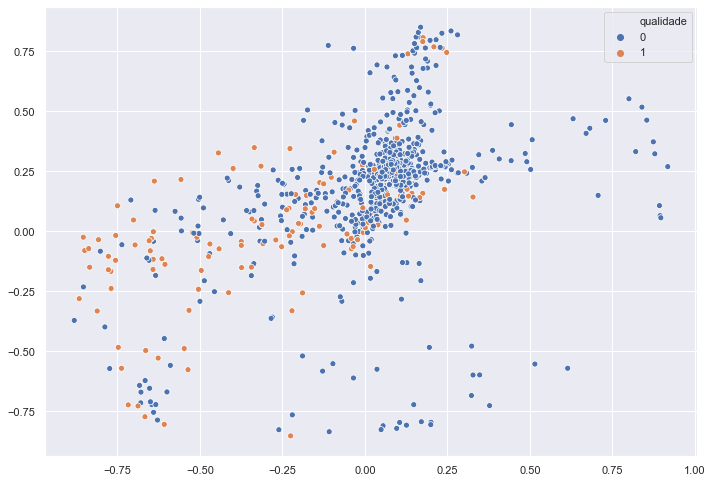

In [12]:
# Gráfico de dispersão das dimensões do AutoEncoder
sns.scatterplot(encoded_train[:,0], 
                encoded_train[:,1], 
                hue=y_train, 
                legend='full');

### Modelo: Gradient Tree Boosting com AutoEncoder

In [13]:
modelo_ae = GradientBoostingClassifier(random_state=42, 
                                       n_estimators=50)
modelo_ae.fit(encoded_train, y_train)

GradientBoostingClassifier(n_estimators=50, random_state=42)

### Desempenho do modelo

In [15]:
calcula_desempenho(modelo_ae, encoded_train, y_train, encoded_test, y_test)

,Treino,Teste,Variação
Acurácia,0.915103,0.875000,-0.04
AUROC,0.899849,0.863196,-0.04
KS,0.725697,0.580789,-0.20
Precision,0.876712,0.612903,-0.30
Recall,0.426667,0.283582,-0.34
F1,0.573991,0.387755,-0.32


## t-SNE

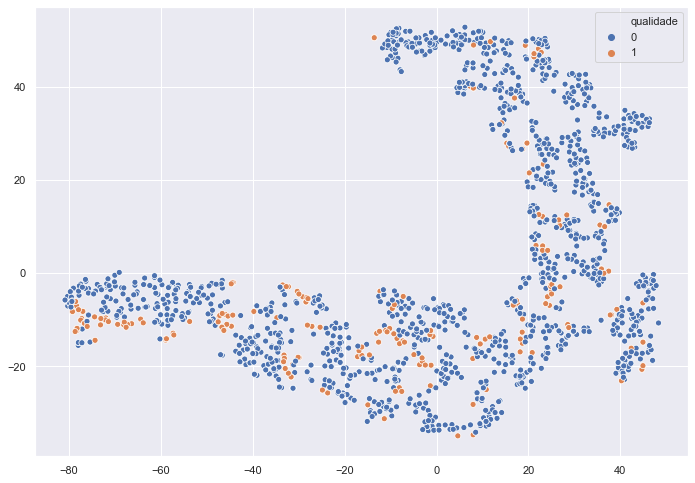

In [21]:
from sklearn.manifold import TSNE

# Seleção apenas das variáveis explicativas
X = df.iloc[:,1:].values.astype('float32')

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Plotagem dos componentes t-SNE
sns.scatterplot(X_tsne[:,0], 
                X_tsne[:,1], 
                hue=y, 
                legend='full');